In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm


In [8]:

# Download the MNIST dataset and create data loaders
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)



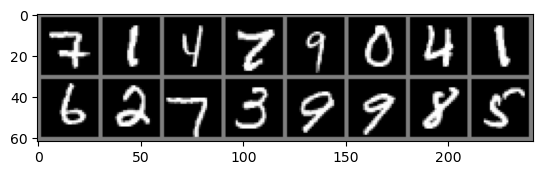

Labels: 7 1 4 7 9 0 4 1 6 2 7 3 9 9 8 5


In [9]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

In [10]:
# Let's define a simple CNN to classify digits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



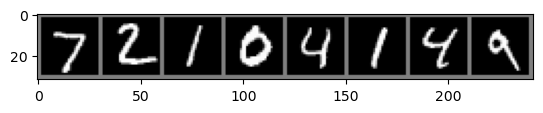

Predicted: 9 9 9 9 9 9 4 9


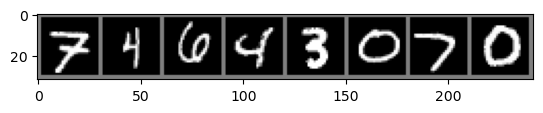

Predicted: 7 6 2 4 8 0 7 0


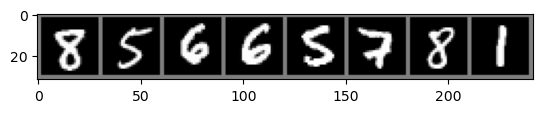

Predicted: 8 5 6 6 5 7 8 1


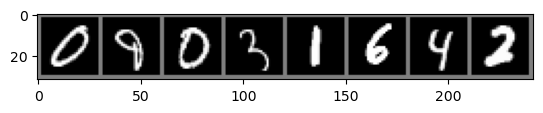

Predicted: 0 3 0 8 8 6 4 2


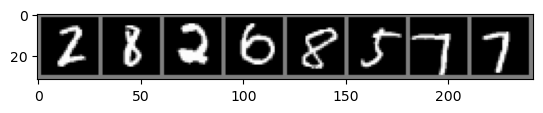

Predicted: 1 8 2 0 5 5 7 7


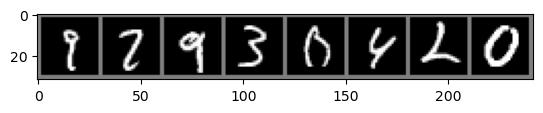

Predicted: 7 2 9 3 0 4 2 0


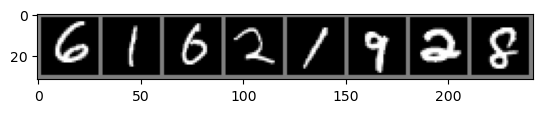

Predicted: 6 1 6 2 1 9 2 8


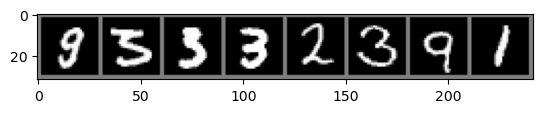

Predicted: 8 3 3 3 2 3 9 1


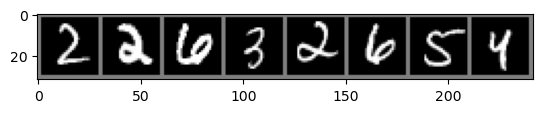

Predicted: 2 2 0 3 4 6 8 4


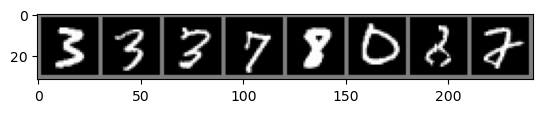

Predicted: 3 3 3 7 8 0 2 8


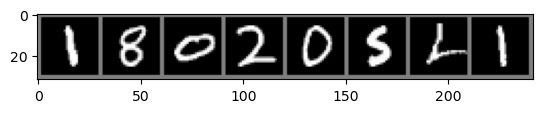

Predicted: 1 8 7 2 0 5 1 1


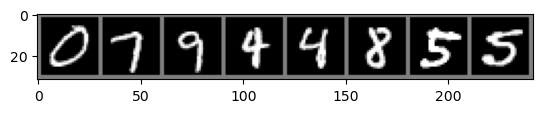

Predicted: 0 7 9 4 4 8 5 5


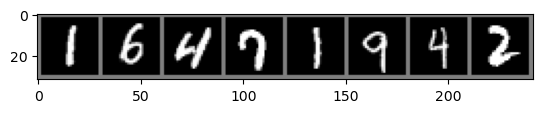

Predicted: 1 6 4 7 1 9 4 2


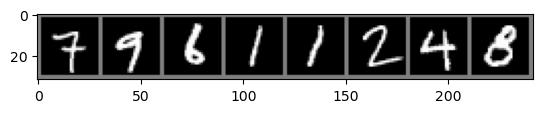

Predicted: 7 9 6 1 1 2 4 3


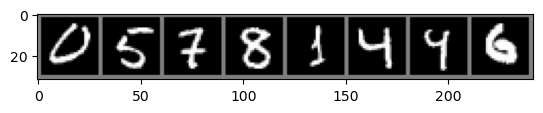

Predicted: 0 5 3 8 1 4 4 6


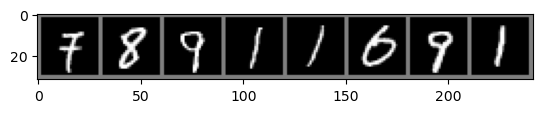

Predicted: 7 8 9 1 1 0 9 1


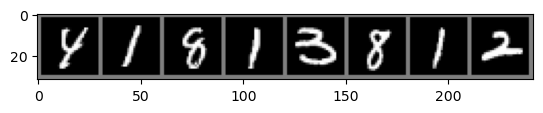

Predicted: 4 1 8 1 3 8 1 2


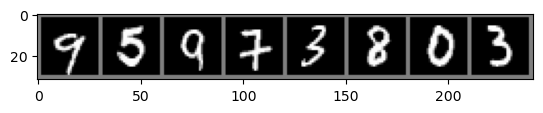

Predicted: 9 5 9 7 3 8 0 3


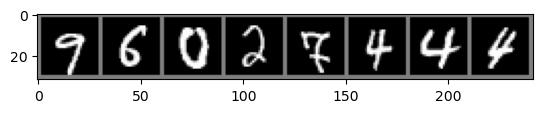

Predicted: 9 0 0 2 1 4 4 4


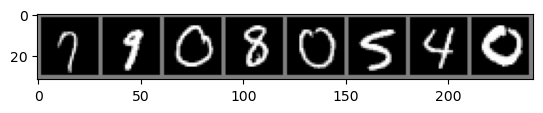

Predicted: 7 9 0 8 0 5 4 0


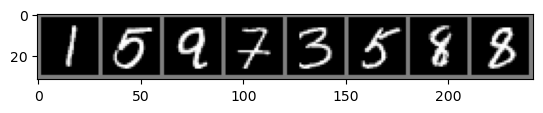

Predicted: 1 5 9 7 3 5 8 8


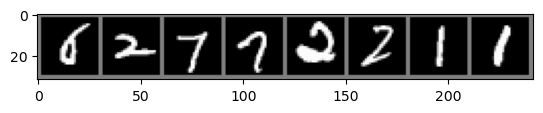

Predicted: 6 2 7 7 2 2 1 1


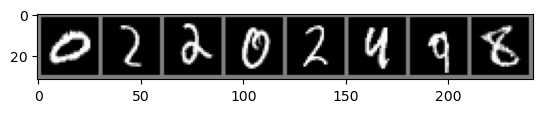

Predicted: 0 2 2 0 2 4 9 8


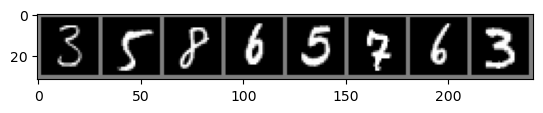

Predicted: 3 5 8 6 5 7 6 3


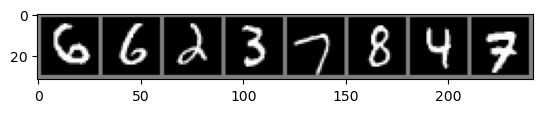

Predicted: 6 6 2 3 7 8 4 7


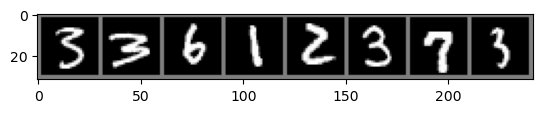

Predicted: 3 3 6 1 2 3 7 3


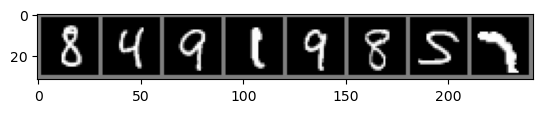

Predicted: 8 4 9 1 9 8 8 7


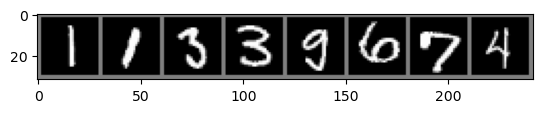

Predicted: 1 1 3 3 9 6 7 4


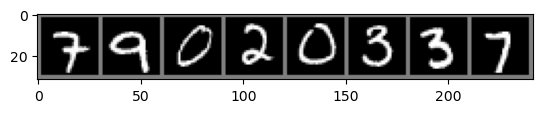

Predicted: 7 9 0 2 0 3 3 7


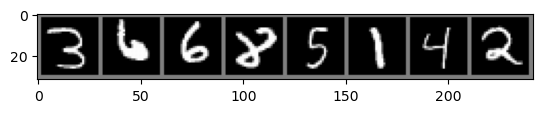

Predicted: 3 5 6 8 5 1 4 2


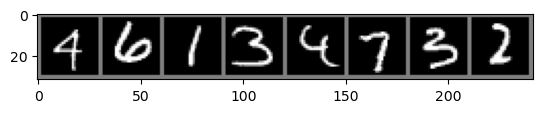

Predicted: 4 6 1 3 4 7 3 2


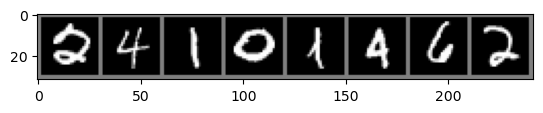

Predicted: 2 4 1 0 1 4 6 2


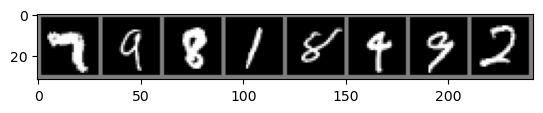

Predicted: 7 4 8 1 8 9 9 2


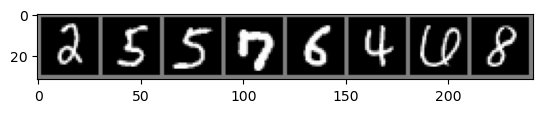

Predicted: 2 5 5 7 6 4 0 8


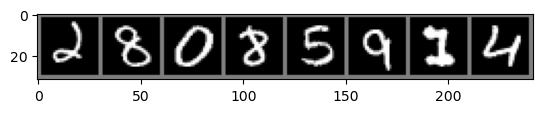

Predicted: 2 8 0 8 5 9 2 4


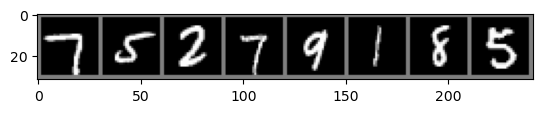

Predicted: 7 5 2 7 9 1 8 5


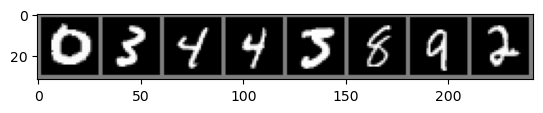

Predicted: 0 3 4 4 3 8 9 2


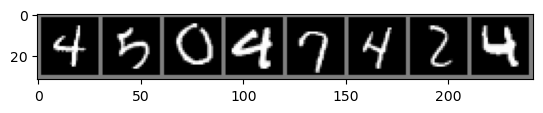

Predicted: 4 5 0 4 7 4 2 4


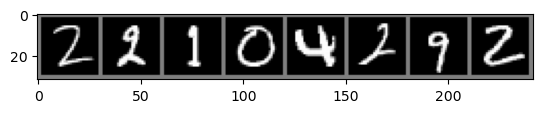

Predicted: 2 2 1 0 4 2 9 2


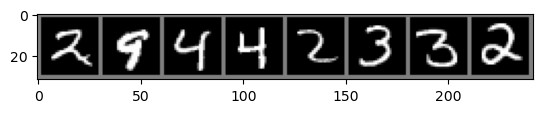

Predicted: 2 9 4 4 2 3 3 2


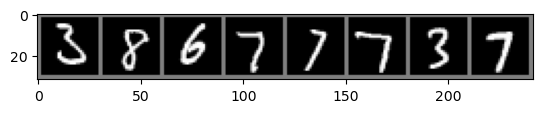

Predicted: 3 8 6 7 7 7 3 7


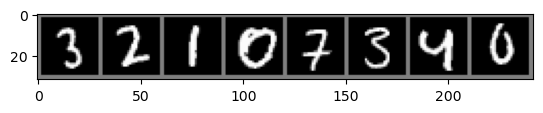

Predicted: 3 2 1 0 7 3 4 6


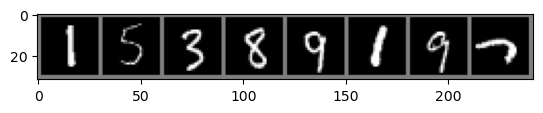

Predicted: 1 5 3 8 9 1 9 7


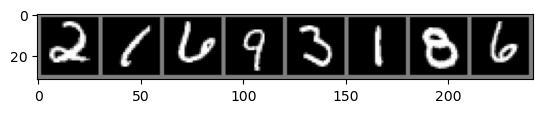

Predicted: 2 1 6 9 3 1 8 6


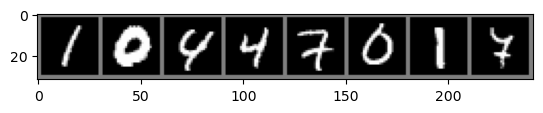

Predicted: 1 0 4 4 7 0 1 7


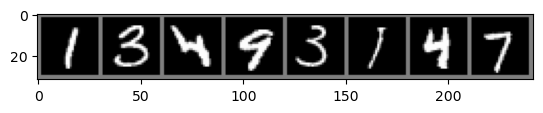

Predicted: 1 3 4 9 3 1 4 7


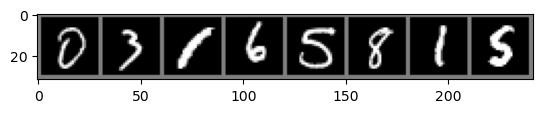

Predicted: 0 9 1 6 5 8 1 5
Epoch 1, Loss: 0.2735099254994155


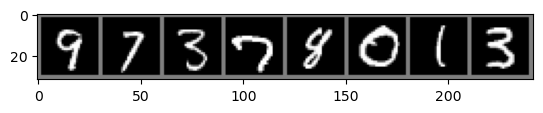

Predicted: 9 7 3 7 4 0 1 3


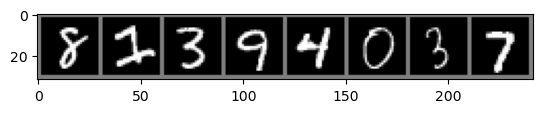

Predicted: 8 2 3 9 4 0 3 7


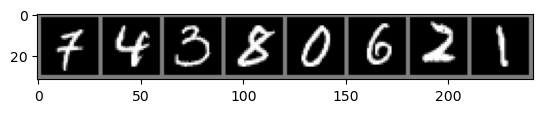

Predicted: 7 4 3 8 0 6 2 1


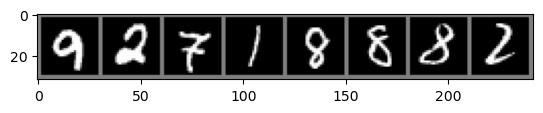

Predicted: 9 2 7 1 8 8 3 2


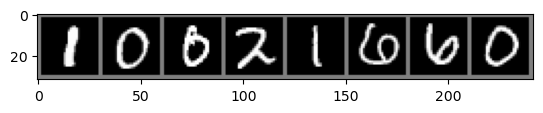

Predicted: 1 0 0 2 1 6 6 0


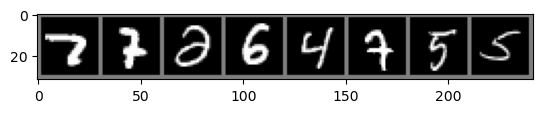

Predicted: 7 2 2 6 4 7 5 5


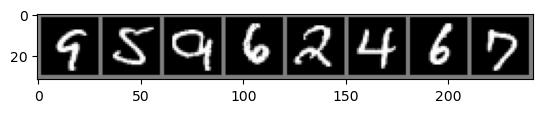

Predicted: 9 5 9 6 2 4 6 7


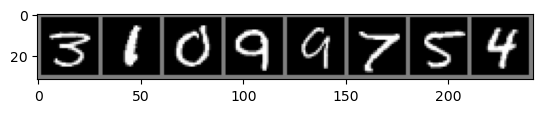

Predicted: 3 1 0 9 9 7 5 4


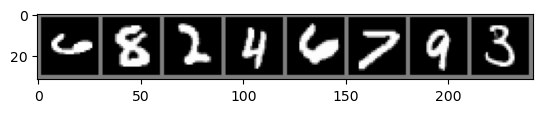

Predicted: 4 8 1 4 6 7 9 3


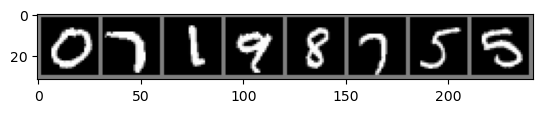

Predicted: 0 7 1 9 8 7 5 5


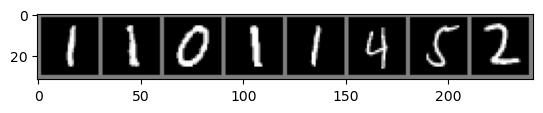

Predicted: 1 1 0 1 1 4 5 2


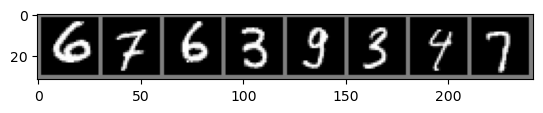

Predicted: 6 7 6 3 9 3 4 7


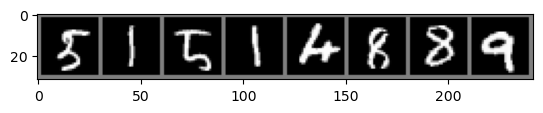

Predicted: 5 1 5 1 4 8 2 9


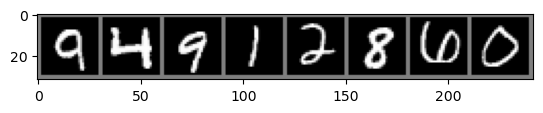

Predicted: 9 4 9 1 2 8 6 0


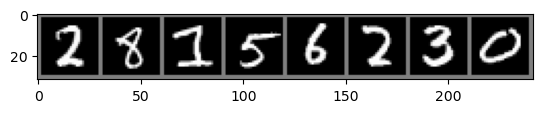

Predicted: 2 8 2 5 6 2 3 0


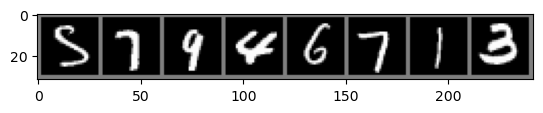

Predicted: 8 7 9 4 6 7 1 3


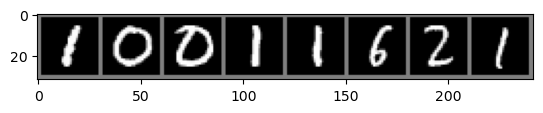

Predicted: 1 0 0 1 1 6 2 1


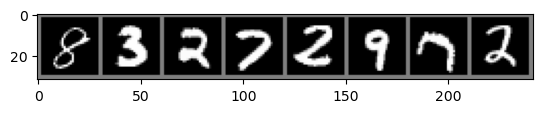

Predicted: 8 3 2 7 2 9 9 2


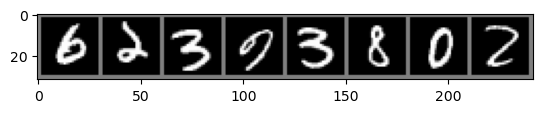

Predicted: 6 2 3 9 3 8 0 2


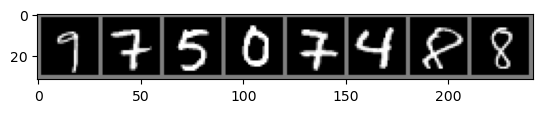

Predicted: 7 7 5 0 7 4 8 8


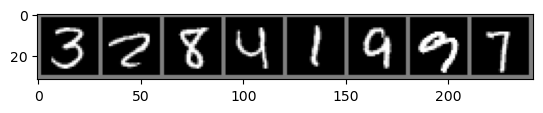

Predicted: 3 2 8 4 1 9 7 7


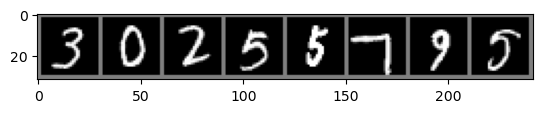

Predicted: 3 0 2 5 5 7 9 5


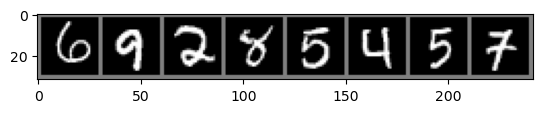

Predicted: 6 9 2 6 5 4 5 7


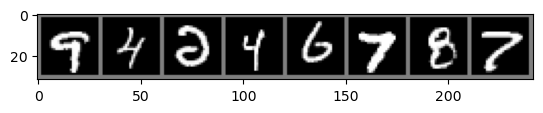

Predicted: 9 4 2 4 6 7 8 7


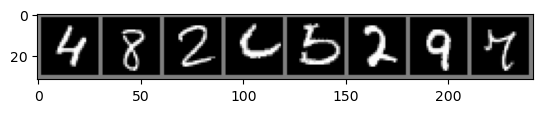

Predicted: 4 8 2 6 5 2 9 7


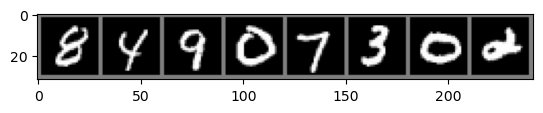

Predicted: 8 4 9 0 7 3 0 4


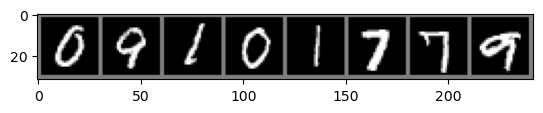

Predicted: 0 9 1 0 1 7 7 9


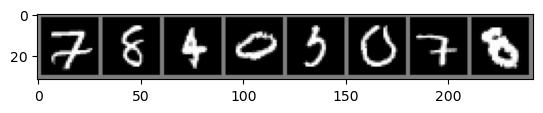

Predicted: 7 8 4 0 3 0 7 8


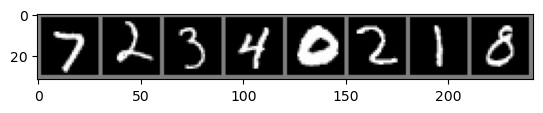

Predicted: 7 2 3 4 0 2 1 0


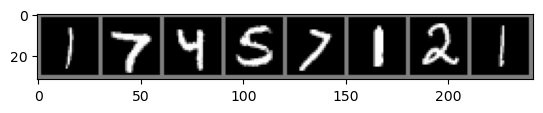

Predicted: 1 7 4 5 7 1 2 1


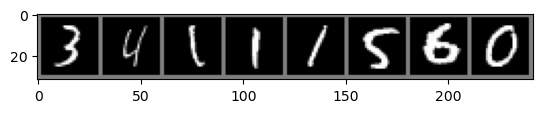

Predicted: 3 4 1 1 1 5 6 0


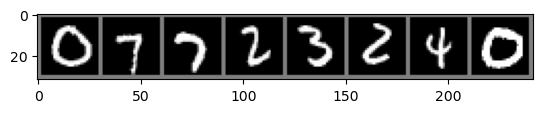

Predicted: 0 7 7 2 3 2 4 0


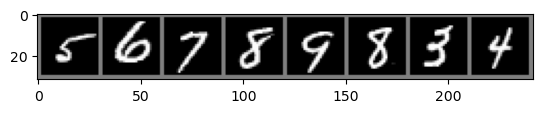

Predicted: 5 6 7 8 9 8 3 4


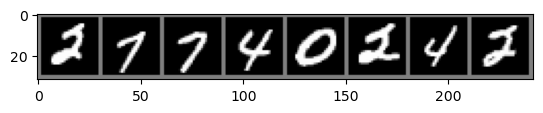

Predicted: 2 7 7 4 0 2 4 2


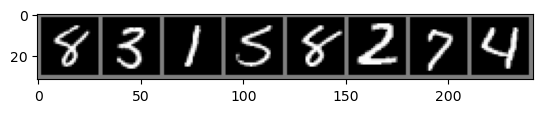

Predicted: 8 3 1 5 8 2 7 4


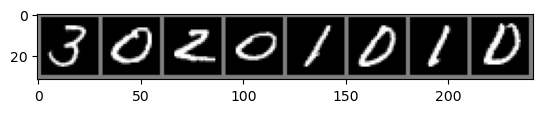

Predicted: 3 0 2 0 1 0 1 0


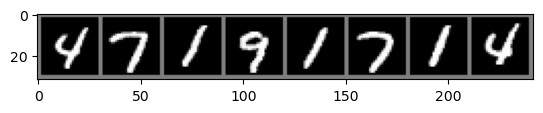

Predicted: 4 7 1 9 1 7 1 4


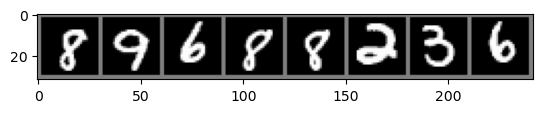

Predicted: 8 9 6 8 8 2 3 6


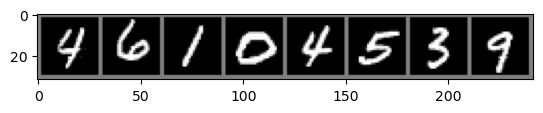

Predicted: 4 6 1 0 4 5 3 9


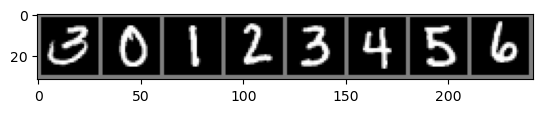

Predicted: 3 0 1 2 3 4 5 6


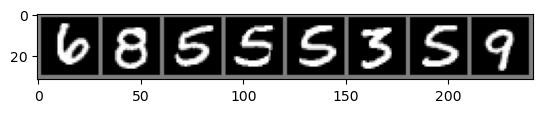

Predicted: 6 8 5 5 5 3 5 9


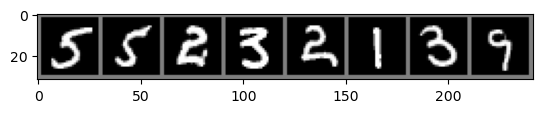

Predicted: 5 5 2 3 2 1 3 9


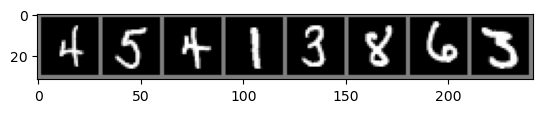

Predicted: 4 5 4 1 3 8 6 3


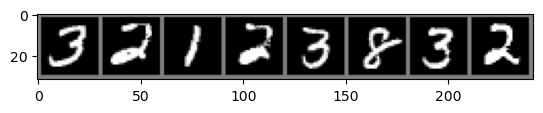

Predicted: 3 2 1 2 3 8 3 2


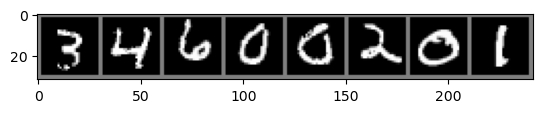

Predicted: 3 4 6 0 6 2 0 1


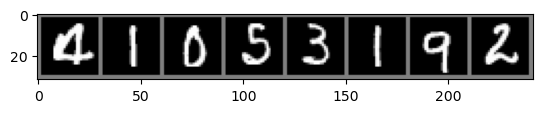

Predicted: 4 1 0 5 3 1 9 2


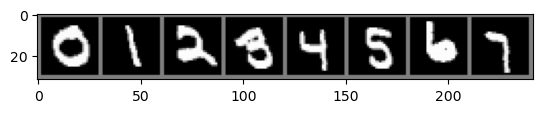

Predicted: 0 1 2 8 4 5 6 7
Epoch 2, Loss: 0.11076231343524733


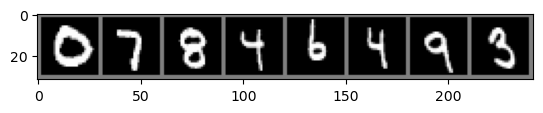

Predicted: 0 7 8 4 6 4 9 3


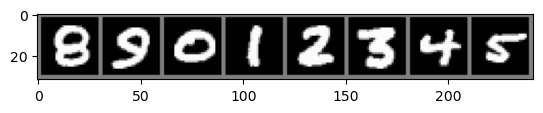

Predicted: 2 9 0 1 2 3 4 5


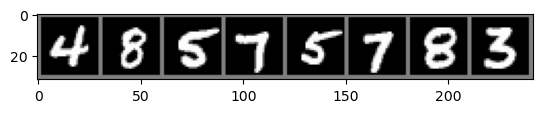

Predicted: 4 8 5 7 5 7 8 3


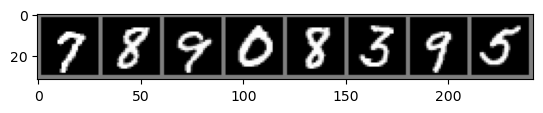

Predicted: 7 8 9 0 8 3 9 5


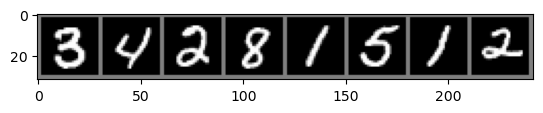

Predicted: 3 4 2 8 1 5 1 2


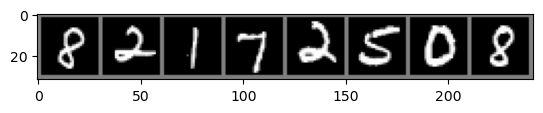

Predicted: 8 2 1 7 2 5 0 8


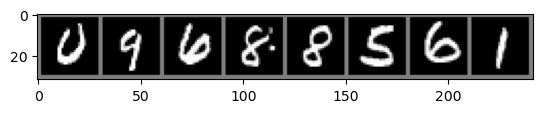

Predicted: 0 9 6 8 8 5 6 1


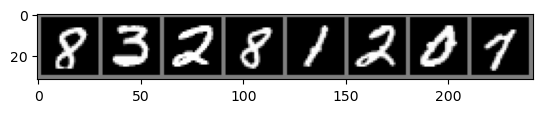

Predicted: 8 3 2 8 1 2 0 7


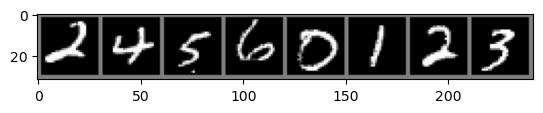

Predicted: 2 4 5 6 0 1 2 3


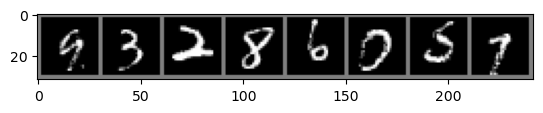

Predicted: 9 3 2 8 6 7 5 7


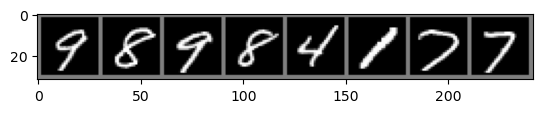

Predicted: 9 8 9 8 4 1 7 7


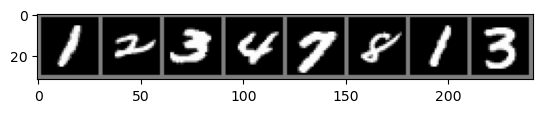

Predicted: 1 2 3 4 7 8 1 3


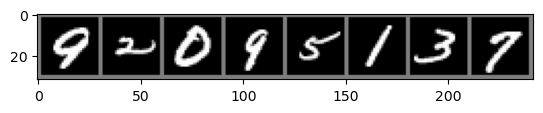

Predicted: 9 2 0 9 5 1 3 9


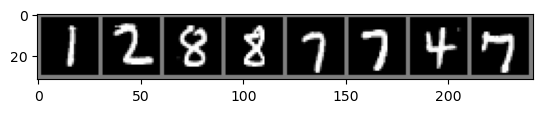

Predicted: 1 2 8 8 7 7 4 7


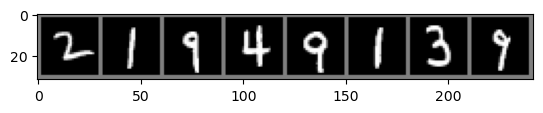

Predicted: 2 1 9 4 9 1 3 9


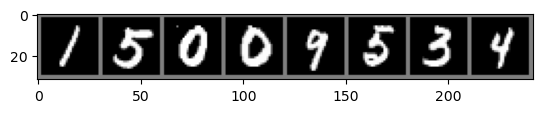

Predicted: 1 5 0 0 9 5 3 4


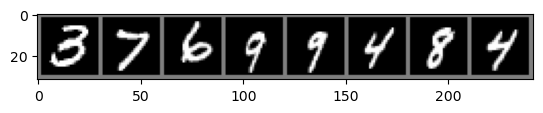

Predicted: 3 7 6 9 9 4 8 4


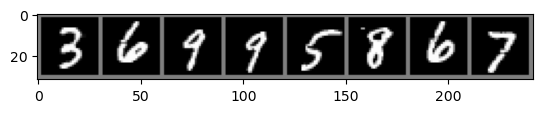

Predicted: 3 6 9 9 5 8 6 7


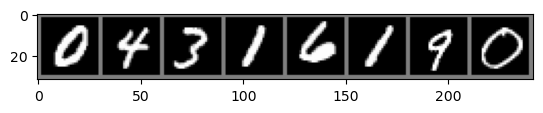

Predicted: 0 4 3 1 6 1 9 0


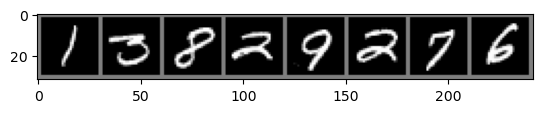

Predicted: 1 3 8 2 9 2 7 6


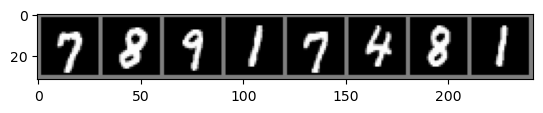

Predicted: 7 8 9 1 7 4 8 1


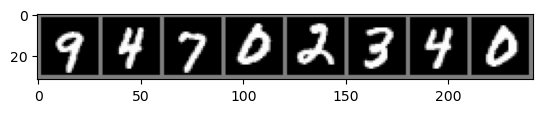

Predicted: 9 4 7 0 2 3 4 0


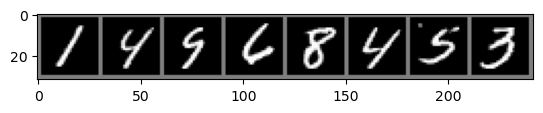

Predicted: 1 4 9 6 8 4 5 3


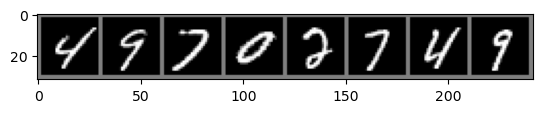

Predicted: 4 9 7 0 2 7 4 9


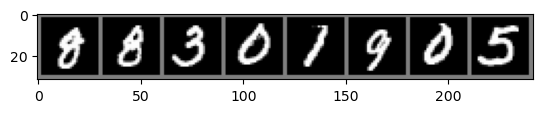

Predicted: 8 8 3 0 1 9 0 5


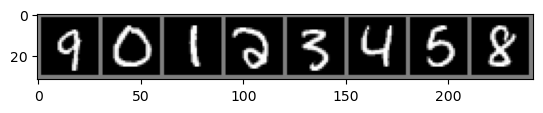

Predicted: 9 0 1 2 3 4 5 8


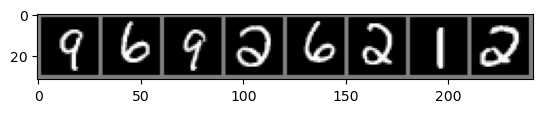

Predicted: 9 6 9 2 6 2 1 2


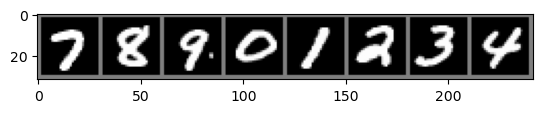

Predicted: 7 8 9 0 1 2 3 4


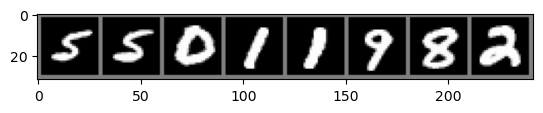

Predicted: 5 5 0 1 1 9 8 2


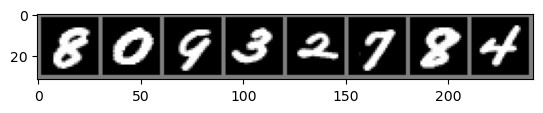

Predicted: 8 0 9 3 2 7 8 4


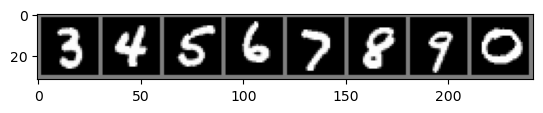

Predicted: 3 4 5 6 7 8 9 0


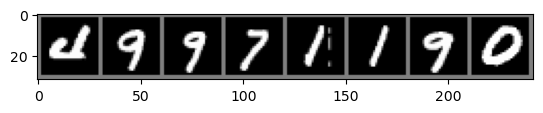

Predicted: 4 9 9 7 1 1 9 0


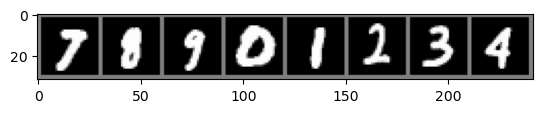

Predicted: 7 8 9 0 1 2 3 4


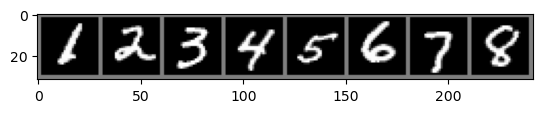

Predicted: 1 2 3 4 5 6 7 8


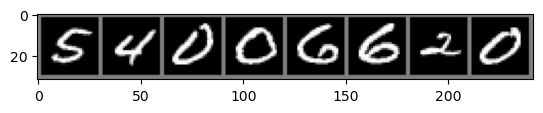

Predicted: 5 4 0 0 0 6 2 0


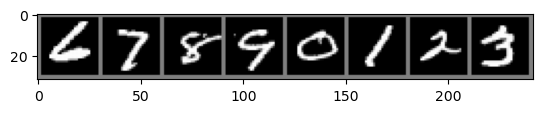

Predicted: 6 7 8 9 0 1 2 3


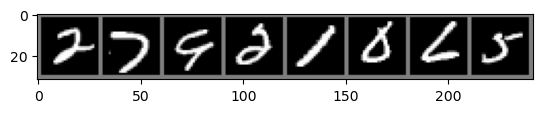

Predicted: 2 7 9 2 1 0 6 5


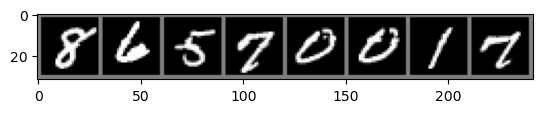

Predicted: 8 6 5 7 0 0 1 7


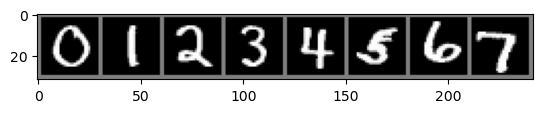

Predicted: 0 1 2 3 4 5 6 7


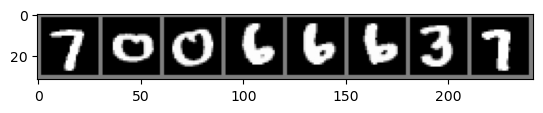

Predicted: 7 7 0 6 6 6 3 7


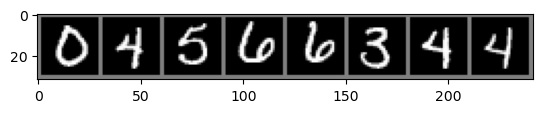

Predicted: 0 4 5 6 6 3 4 4


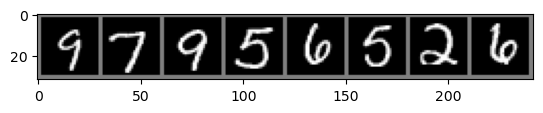

Predicted: 9 7 9 5 6 5 2 6


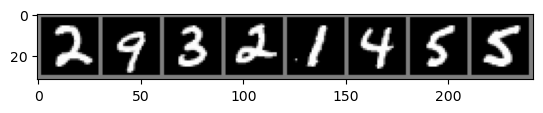

Predicted: 2 9 3 2 1 4 5 5


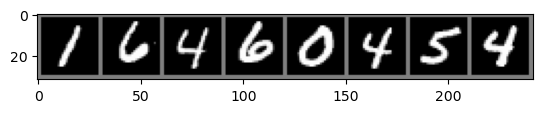

Predicted: 1 6 4 6 0 4 5 4


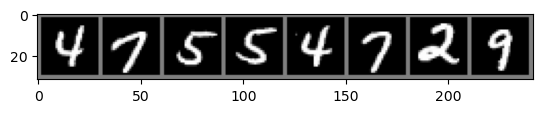

Predicted: 4 7 5 5 4 7 2 9


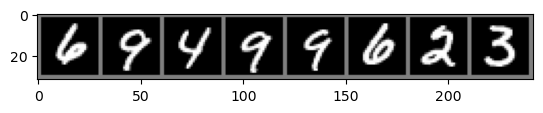

Predicted: 6 9 4 9 9 6 2 3


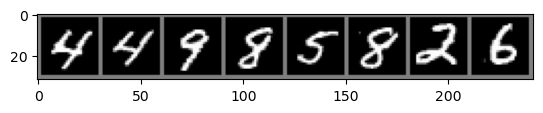

Predicted: 4 4 9 8 5 8 2 6
Epoch 3, Loss: 0.08848855939871475


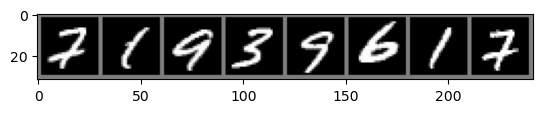

Predicted: 7 1 9 3 9 6 1 7


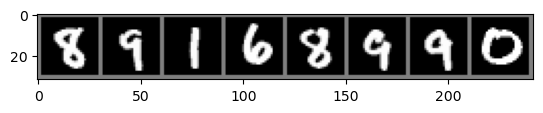

Predicted: 8 9 1 6 8 9 9 0


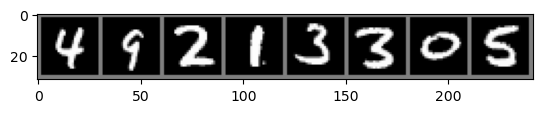

Predicted: 4 9 2 1 3 3 0 5


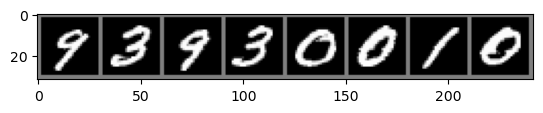

Predicted: 9 3 9 3 0 0 1 0


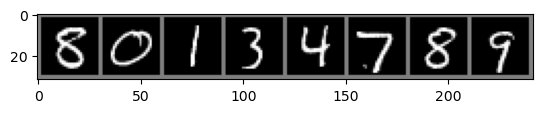

Predicted: 8 0 1 3 4 7 8 9


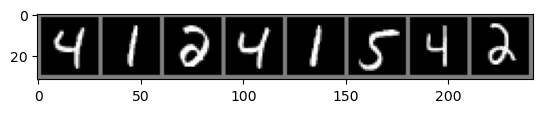

Predicted: 4 1 2 4 1 5 4 2


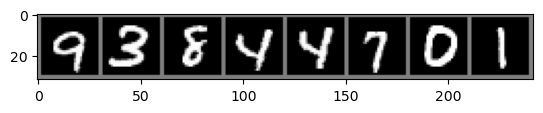

Predicted: 9 3 8 4 4 7 0 1


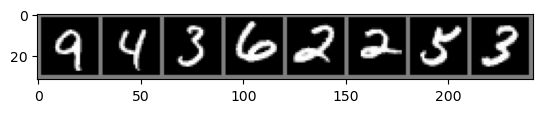

Predicted: 9 4 3 6 2 2 5 3


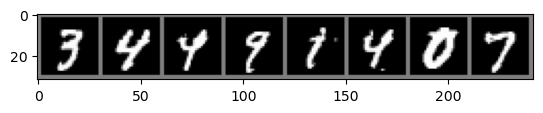

Predicted: 3 4 4 9 8 4 0 7


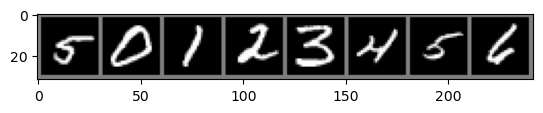

Predicted: 5 0 1 2 3 4 5 6


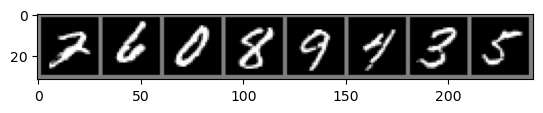

Predicted: 7 6 0 8 9 7 3 5


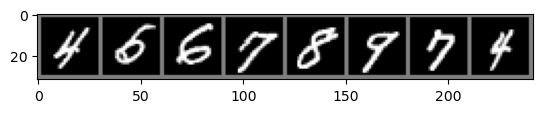

Predicted: 4 6 6 7 8 9 7 4


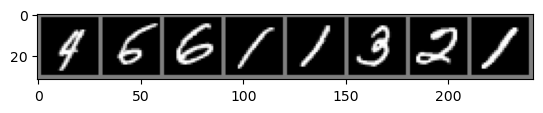

Predicted: 4 6 6 1 1 3 2 1


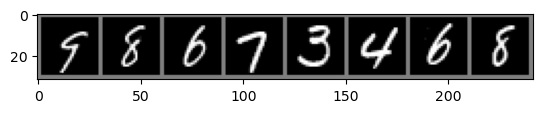

Predicted: 9 8 6 7 3 4 6 8


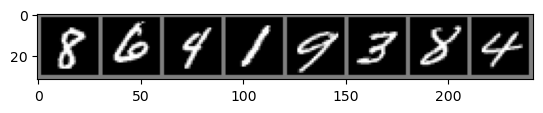

Predicted: 8 6 4 1 9 3 8 4


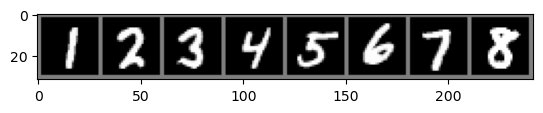

Predicted: 1 2 3 4 5 6 7 8


StopIteration: 

In [13]:
# Number of training epochs
num_epochs = 5

testiter = iter(testloader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.next()
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')
